# Hyperparameter Tuning

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from sklearn.model_selection import KFold
from utils import *
from torch.utils.data import random_split
import matplotlib.pyplot as plt


### Set your dataset directory

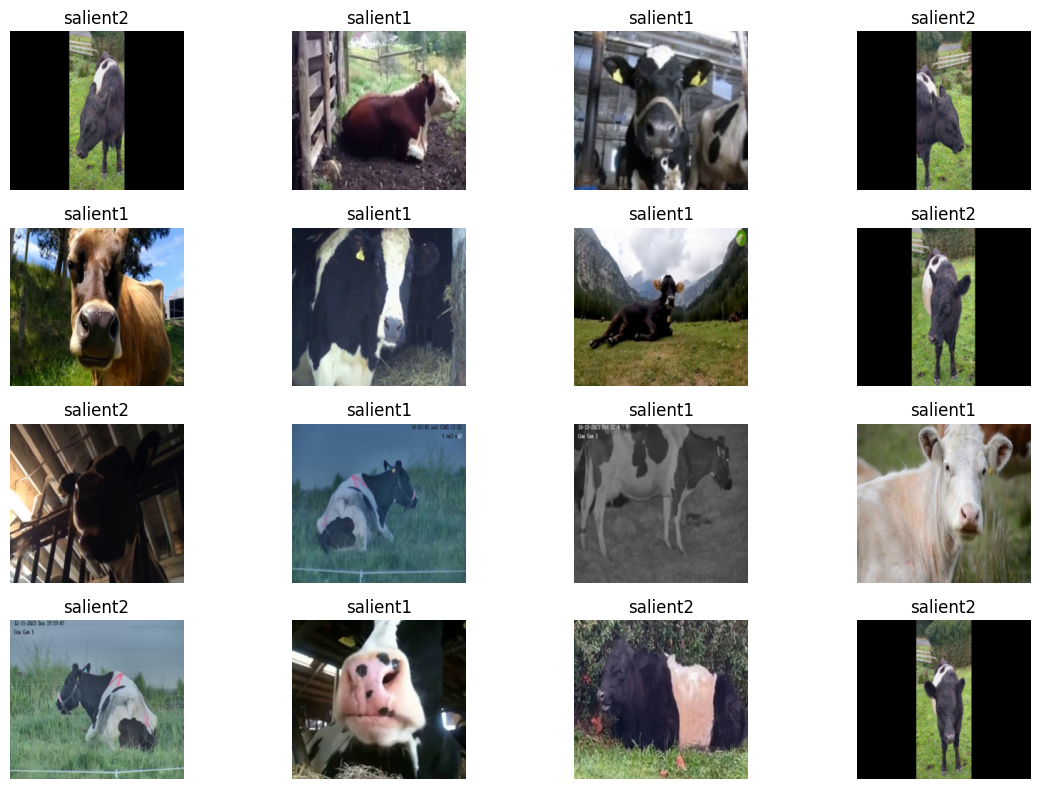

In [2]:
data_dir = '../../data/BiteCount/salient_poses/' 

# Define transformations for training set and validation set
train_transforms = transforms.Compose([
    transforms.Resize((224, 244)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 244)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the dataset with training transformations
dataset = datasets.ImageFolder(data_dir, transform=train_transforms)
dataset_size = len(dataset)
class_names = dataset.classes

# # Cross-validation setup
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Split the dataset randomly into training and validation sets
train_size = int(0.8 * dataset_size)  # 80% training, 20% validation
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders for train and validation datasets
train_loader = DataLoader(train_dataset, batch_size=196, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Display images from the training DataLoader (for example)
data_iter = iter(train_loader) 
images, labels = next(data_iter)
show_images(images, labels, class_names) 


### Set your model and parameters

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize model, criterion, optimizer
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Perform 5-Fold Cross Validation
fold_idx = 1
num_epochs = 25
patience = 5

/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Tune the model

In [4]:
# Tuning: Experiment with different values for learning rate and momentum
learning_rates = [0.0001, 0.001, 0.01]
momentums = [0.8, 0.9, 0.99]

best_val_acc = 0.0
best_lr = None
best_momentum = None

for lr in learning_rates:
    for mom in momentums:
        print(f"Training with learning rate: {lr} and momentum: {mom}")
        
        # Initialize model and optimizer with current hyperparameters
        model = models.resnet50(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, len(class_names))
        model = model.to(device)

        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=mom)
        
        # Training loop with early stopping mechanism
        val_acc, _, _, _, _, _, _= train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience, device)
        
        # Check if current validation accuracy is the best so far
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_lr = lr
            best_momentum = mom

print(f"Best Learning Rate: {best_lr}, Best Momentum: {best_momentum}, Validation Accuracy: {best_val_acc}")


Training with learning rate: 0.0001 and momentum: 0.8
Epoch [1/25] - Train Loss: 0.7014, Train Acc: 0.5035, Val Loss: 0.7047, Val Acc: 0.4889
Validation accuracy improved to 0.4889. Saving model.
Epoch [2/25] - Train Loss: 0.7009, Train Acc: 0.4936, Val Loss: 0.7066, Val Acc: 0.4691
Epoch [3/25] - Train Loss: 0.6988, Train Acc: 0.4997, Val Loss: 0.7054, Val Acc: 0.4784
Epoch [4/25] - Train Loss: 0.6982, Train Acc: 0.5018, Val Loss: 0.7029, Val Acc: 0.4737
Epoch [5/25] - Train Loss: 0.6970, Train Acc: 0.5000, Val Loss: 0.7028, Val Acc: 0.4842
Epoch [6/25] - Train Loss: 0.6966, Train Acc: 0.4959, Val Loss: 0.7013, Val Acc: 0.4807
Early stopping triggered.
Training with learning rate: 0.0001 and momentum: 0.9
Epoch [1/25] - Train Loss: 0.7018, Train Acc: 0.4953, Val Loss: 0.6948, Val Acc: 0.5204
Validation accuracy improved to 0.5204. Saving model.
Epoch [2/25] - Train Loss: 0.6999, Train Acc: 0.4965, Val Loss: 0.6968, Val Acc: 0.5146
Epoch [3/25] - Train Loss: 0.6973, Train Acc: 0.5055, 

Best Learning Rate: 0.01, Best Momentum: 0.8, Validation Accuracy: 0.9579929988331388